## Imports for functions

In [41]:
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from multiprocessing import Pool, cpu_count
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

## Functions

### im_multi

Summary: The function 'im_multi' takes the input file path of an image and outputs [path, {'size': size of image at path}] for easier access to the size.

In [42]:
def im_multi(path):
    #Input: file path of image
    #Output: [path, {'size': size of image at path}]
    try:
        im_stats_im_ = Image.open(path) #im_stats_im holds the image at 'path'
        return [path, {'size': im_stats_im_.size}] #im_stats_im.size returns the size of the image as [width, height] 
    except:
        print(path)
        return [path, {'size': [0,0]}]

### im_stats

Summary: The function 'im_stats' takes the input dataframe and adds an extra column containing the sizes of each image in the training data set.

In [43]:
def im_stats(im_stats_df): 
    #Input: dataframe of training images (type, image, path)
    #Output: dataframe of training images (type, image, path, size)
    im_stats_d = {}
    p = Pool(cpu_count())
    ret = p.map(im_multi, im_stats_df['path'])
    #p.map(f, [x, y, z]) returns a list [f[x], f[y], f[z]]
    #For all paths in the inputted dataframe im_stats_df, they are passed through im_multi
    #ret holds [[path, {'size': size of image at path}], ...]
    for i in range(len(ret)):
        im_stats_d[ret[i][0]] = ret[i][1]
    im_stats_df['size'] = im_stats_df['path'].map(lambda x: ' '.join(str(s) for s in 
                                                                     im_stats_d[x]['size']))
    #Adds additional column to original dataframe and formats size as 3264 4160''
    return im_stats_df

### get_im_cv2

Summary: The function 'get_im_cv2' takes the input file path to an image and returns a 64x64 resized version of the source image.

In [44]:
def get_im_cv2(path):
    #Input: file path of image
    #Output: [original path, resized image]
    img = cv2.imread(path)
    resized = cv2.resize(img, (64, 64), cv2.INTER_LINEAR) #INTER_LINEAR is algorithm 
    #to downsize image
    #I could try using INTER_AREA as, according to the URL below, could be better
    #http://tanbakuchi.com/posts/comparison-of-openv-interpolation-algorithms/
    return [path, resized]

### normalize_image_features

Summary: The function 'normalize_image_features' takes the input list of image file paths and returns a list containing transposed versions of the source images.  This is necessary for the images to enter the Conv2d layer.

In [45]:
def normalize_image_features(paths):
    #Input: list of paths
    #Output: list of resized images that have been transposed for Conv2d layer
    imf_d = {}
    p = Pool(cpu_count())
    ret = p.map(get_im_cv2, paths)
    #ret holds a list: [[image path, resized image], ...]
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
        #imf_d[image path in ret] = resized image
    ret = []
    fdata = [imf_d[f] for f in paths]
    #fdata holds a list: [resized image, ...]
    fdata = np.array(fdata, dtype=np.uint8)
    #fdata is now a numbpy array of ints
    fdata = fdata.transpose((0, 3, 1, 2))
    #Usually its (2, 0, 1) since it changes the image from (0, 1, 2)->(width, height, channel)
    #to (2, 0, 1)->(channel, width, height) for the Conv2d layer, 
    #but since we have 4 dimensions, it gets bumped up one to (3, 1, 2);
    fdata = fdata.astype('float32')
    fdata = fdata / 255
    #fdata now has values between 0 and 1
    return fdata

## Loading data

Summary: This block loads both the training and testing data.  It saves the training images in 'train.npy' and their corresponding labels in 'train_target.npy'.  The test images are saved in 'test.npy', and their corresponding file names are saved in 'test_id.npy'.

In [46]:
train = glob.glob("/Users/keerat/dev/AOSResearch/resources/Train/**/*.jpg")
#train is an array holding all of the path files in the training set
print("Number of files in training set: %", len(train))
train = pd.DataFrame([[p.split('/')[7],p.split('/')[8],p] for p in train], columns = 
                     ['type','image','path'])[::1]
#train is a dataframe holding the type (ex. "Type_1"), image name (ex. "0.jpg"), and file path
#(ex. "/Users/keerat/dev/AOSResearch/resources/Train/Type_1/0.jpg")
train = im_stats(train)
#train now has additional column with size (ex. 3264 4160)
train = train[train['size'] != '0 0'].reset_index(drop=True) #corrupt images removed
#train now has an additional column with the index reset to 0, 1, 2, 3... instead of 0, 5, 10..
print("loading train data")
train_data = normalize_image_features(train['path'])
#train_data holds a usable set of training images for the CNN
print("train data loaded")
np.save('train.npy', train_data, allow_pickle=True, fix_imports=True)
#train.npy is a file that has all of the image arrays in train_data

le = LabelEncoder()
train_target = le.fit_transform(train['type'].values) 
#train_target holds type of each image in train
#Type_1 = 0, Type_2 = 1, Type_3 = 2
#For example, if the 40th image in train is Type_1, then train_target[40] = 0
print(le.classes_)  
np.save('train_target.npy', train_target, allow_pickle=True, fix_imports=True)
#train_target.npy is a file that has all values of train_target

test = glob.glob("/Users/keerat/dev/AOSResearch/resources/test/*.jpg")
#test is an array holding all of the path files in the test set
test = pd.DataFrame([[p.split('/')[7],p] for p in test], columns = ['image','path']) [::1]
#test is a dataframe holding the image name (ex. "0.jpg"), and file path
#(ex. "/Users/keerat/dev/AOSResearch/resources/test/0.jpg")
print("loading test data")
test_data = normalize_image_features(test['path'])
#test_data holds a usable set of test images for the CNN
np.save('test.npy', test_data, allow_pickle=True, fix_imports=True)
#test.npy is a file that has all of the image arrays in test_data
print("test data loaded")
test_id = test.image.values
np.save('test_id.npy', test_id, allow_pickle=True, fix_imports=True)
#test_id.npy is a file that has all of the image names (ex. '0.jpg) in test_data

Number of files in training set: % 1800


/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: U

/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11059. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11211. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3640590336 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3640590336 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/Tif

/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 661848064 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 460914688 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1452606336 bytes but only got 0. Skipping tag 14533
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 13241. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/Tiff

/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10541. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 759562240 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 581632000 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 536150016 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImage

/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11840. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19232248408 bytes but only got 0. Skipping tag 39334
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 497680384 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 217972736 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/Tif

/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 450756608 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10020. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 473366528 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10365. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffI

/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12030. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 14507. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669450240 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 713490432 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffI

/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 12054. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 465174528 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 465371136 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 10240. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/keerat/anaconda/lib/python3.6/site-packages/PIL/TiffI

loading train data
train data loaded
['Type_1' 'Type_2' 'Type_3']
loading test data
test data loaded


## Imports for model

In [47]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import backend as K
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot

In [48]:
train_data = np.load('train.npy')
train_target = np.load('train_target.npy')

## CNN model

Model summary:

Layer 1: Convolutional layer
<br>
Layer 2: Max Pooling layer
<br>
Layer 3: Convolutional layer
<br>
Layer 4: Max Pooling layer
<br>
Layer 5: Dropout layer
<br>
Layer 6: Flatten layer
<br>
Layer 7: Fully Connected layer
<br>
Layer 8: Dropout layer
<br>
Layer 9: Fully Connected layer

In [49]:
def create_model(opt_='adamax'):
    model = Sequential()
    model.add(Convolution2D(4, 3, 3, activation='relu', dim_ordering='th', 
                            input_shape=(3, 64, 64))) 
    #Could try different input shape
    
    #Activation='relu' to discover nonlinear patterns of data
    #dim_ordering = 'th' to match (0, 3, 1, 2) images were transposed to
    #Four 3x3 filters
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
    model.add(Convolution2D(8, 3, 3, activation='relu', dim_ordering='th'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
    model.add(Dropout(0.2))
    #model.add(Dropout(0.8))
    #model.add(Dropout(0.6))
    #model.add(Dropout(0.4))
    #Sets a fraction of rate of input units to 0 to prevent overfitting
    model.add(Flatten())
    #Creates 1D feature vector for Dense layers
    model.add(Dense(12, activation='tanh')) #Classifies
    model.add(Dropout(0.1))
    #model.add(Dropout(0.7))
    #model.add(Dropout(0.5))
    #model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax')) #Classifies

    model.compile(optimizer=opt_, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #Compiles all layers of model with optimizer, loss function, and metrics (to evaluate 
    #performance)
    return model

### clean_images

Summary: This function adds variation in rotating and zooming in on training images to prevent overfitting.

In [50]:
def cleanImages():
    datagen = ImageDataGenerator(rotation_range=0.3, zoom_range=0.3)
    #rotation_range = random rotation of images up to 0.3 degrees
    #zoom_range = random zoom of images up to a scale of 0.3
    datagen.fit(train_data)
    return datagen

### fitAndPredict

Summary: This function uses 'create_model' to run the training images through the model for 200 epochs.  It then uses the tuned model to predict the labels of the test images.

In [51]:
def fitAndPredict(): #Runs data through model
    print("cleaning images")
    datagen=cleanImages() #datagen now points to the parameters in cleanImages()
    print("images cleaned")
    
    model = create_model() #model holds CNN model
    x_train,x_val_train,y_train,y_val_train = train_test_split(train_data,train_target,
                                                               test_size=0.4, random_state=17)
    #x_train = training set of images (60% of original training set)
    #x_val_train = validation set of images (40 % of original training set)
    #y_train = types for training images
    #y_val_train = types for validation images
    
    #Training set is used to fit the parameters using back prop
    #Validation set is used to fine tune parameters to create a final model
    #Test set is used to assess model's performance
    print("fitting data")
    hist = model.fit_generator(datagen.flow(x_train,y_train, batch_size=15, shuffle=True), 
                        nb_epoch=200, samples_per_epoch=len(x_train), 
                        verbose=2, validation_data=(x_val_train, y_val_train))
    #Training set is augmented real-time with datagen.flow
    #CNN processes images not one at a time, but in batches.  With batch_size = 15, one batch 
    #is 15 x 3 x 64 x 64.  The batch can't be too big, or else the machine can't handle it,
    #and it can't be too small or else there will be no variance within the batch.
    train_loss=hist.history['loss']
    val_loss=hist.history['val_loss']
    train_acc=hist.history['acc']
    val_acc=hist.history['val_acc']
    xc=range(200)

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    print(plt.style.available) # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])
    plt.show()

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])
    plt.show()
    print("data fitted in model")
    test_data = np.load('test.npy')
    test_id = np.load('test_id.npy')
    print("creating predictions")
    predictions = model.predict_proba(test_data)
    #Runs test_data through model and returns probablibity of it being each type
    print("predictions made")
    return predictions

### test

Summary: This function essentially prints the test image predictions from 'fitAndPredict'.  In the boolean 'isTrue', you have the option to either create just a dataframe or also an excel file.

In [52]:
def test(isTrue): #Runs CNN on test images
    pred=fitAndPredict()
    print("creating test file")
    df = pd.DataFrame(pred, columns=['Type_1','Type_2','Type_3']) #Instantiates dataframe
    df['image_name'] = test_id #image_name holds the .jpg file name
    if (isTrue): #if(True), it will create a .csv file with the dataframe
        df.to_csv('test.csv', index=False)
        print("Test file created in users/keerat/...")
    else: #if(False), it will just show the dataframe
        print(df.to_string())

### Main function

Summary: This block runs the test function.

cleaning images


/Users/keerat/anaconda/lib/python3.6/site-packages/keras/preprocessing/image.py:748: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1800, 3, 64, 64) (64 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


images cleaned


/Users/keerat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), activation="relu", input_shape=(3, 64, 64..., data_format="channels_first")`
  after removing the cwd from sys.path.
/Users/keerat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format="channels_first")`
  # Remove the CWD from sys.path while we load stuff.
/Users/keerat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()
/Users/keerat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), d

fitting data


/Users/keerat/anaconda/lib/python3.6/site-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1080, 3, 64, 64) (64 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
/Users/keerat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/Users/keerat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `fit_generator` call to the Ke

Epoch 1/200
 - 12s - loss: 1.0983 - acc: 0.3861 - val_loss: 1.0817 - val_acc: 0.4736
Epoch 2/200
 - 9s - loss: 1.0676 - acc: 0.4389 - val_loss: 1.0502 - val_acc: 0.4792
Epoch 3/200
 - 10s - loss: 1.0411 - acc: 0.4454 - val_loss: 1.0491 - val_acc: 0.4542
Epoch 4/200
 - 10s - loss: 1.0165 - acc: 0.4704 - val_loss: 1.0494 - val_acc: 0.4500
Epoch 5/200
 - 10s - loss: 1.0164 - acc: 0.4741 - val_loss: 1.0348 - val_acc: 0.4681
Epoch 6/200
 - 9s - loss: 1.0094 - acc: 0.4778 - val_loss: 1.0255 - val_acc: 0.4792
Epoch 7/200
 - 9s - loss: 0.9934 - acc: 0.5056 - val_loss: 1.0462 - val_acc: 0.4583
Epoch 8/200
 - 9s - loss: 0.9856 - acc: 0.5000 - val_loss: 1.0206 - val_acc: 0.4861
Epoch 9/200
 - 9s - loss: 0.9885 - acc: 0.5019 - val_loss: 1.0178 - val_acc: 0.4764
Epoch 10/200
 - 9s - loss: 0.9767 - acc: 0.5278 - val_loss: 1.0102 - val_acc: 0.4931
Epoch 11/200
 - 9s - loss: 0.9667 - acc: 0.5139 - val_loss: 1.0177 - val_acc: 0.4819
Epoch 12/200
 - 9s - loss: 0.9488 - acc: 0.5491 - val_loss: 1.0131 - v

Epoch 98/200
 - 8s - loss: 0.5763 - acc: 0.7639 - val_loss: 1.3098 - val_acc: 0.5069
Epoch 99/200
 - 9s - loss: 0.6038 - acc: 0.7537 - val_loss: 1.3016 - val_acc: 0.4903
Epoch 100/200
 - 8s - loss: 0.5696 - acc: 0.7741 - val_loss: 1.3199 - val_acc: 0.4917
Epoch 101/200
 - 9s - loss: 0.5721 - acc: 0.7528 - val_loss: 1.3180 - val_acc: 0.4944
Epoch 102/200
 - 9s - loss: 0.5640 - acc: 0.7741 - val_loss: 1.3359 - val_acc: 0.4847
Epoch 103/200
 - 10s - loss: 0.5513 - acc: 0.7815 - val_loss: 1.3216 - val_acc: 0.4833
Epoch 104/200
 - 10s - loss: 0.5697 - acc: 0.7481 - val_loss: 1.3414 - val_acc: 0.4944
Epoch 105/200
 - 11s - loss: 0.5815 - acc: 0.7593 - val_loss: 1.3497 - val_acc: 0.4681
Epoch 106/200
 - 13s - loss: 0.5544 - acc: 0.7852 - val_loss: 1.3430 - val_acc: 0.4875
Epoch 107/200
 - 11s - loss: 0.5568 - acc: 0.7620 - val_loss: 1.3413 - val_acc: 0.5000
Epoch 108/200
 - 8s - loss: 0.5682 - acc: 0.7694 - val_loss: 1.3522 - val_acc: 0.4819
Epoch 109/200
 - 8s - loss: 0.5623 - acc: 0.7759 - 

Epoch 193/200
 - 9s - loss: 0.4601 - acc: 0.8213 - val_loss: 1.5272 - val_acc: 0.5000
Epoch 194/200
 - 8s - loss: 0.4272 - acc: 0.8296 - val_loss: 1.5477 - val_acc: 0.5222
Epoch 195/200
 - 9s - loss: 0.4193 - acc: 0.8435 - val_loss: 1.5269 - val_acc: 0.5167
Epoch 196/200
 - 9s - loss: 0.4455 - acc: 0.8306 - val_loss: 1.5541 - val_acc: 0.5097
Epoch 197/200
 - 8s - loss: 0.4599 - acc: 0.8093 - val_loss: 1.5719 - val_acc: 0.4944
Epoch 198/200
 - 8s - loss: 0.4563 - acc: 0.8074 - val_loss: 1.5330 - val_acc: 0.5111
Epoch 199/200
 - 9s - loss: 0.4004 - acc: 0.8444 - val_loss: 1.5721 - val_acc: 0.5125
Epoch 200/200
 - 9s - loss: 0.4403 - acc: 0.8269 - val_loss: 1.5725 - val_acc: 0.5014
['_classic_test', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', '

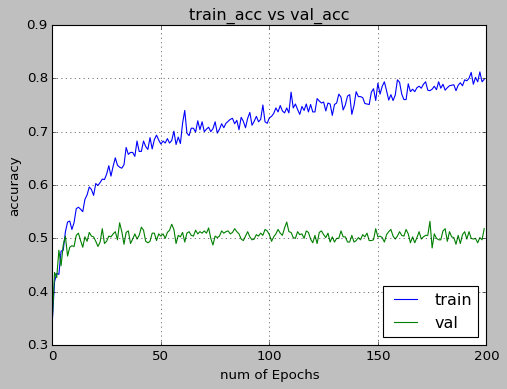

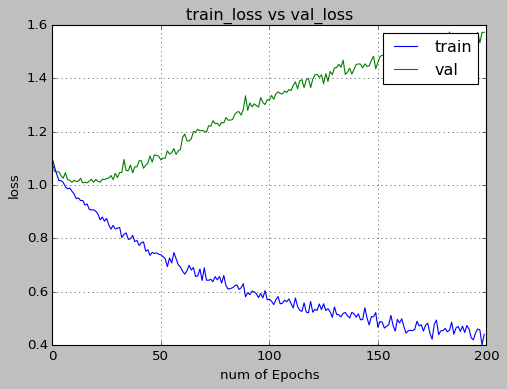

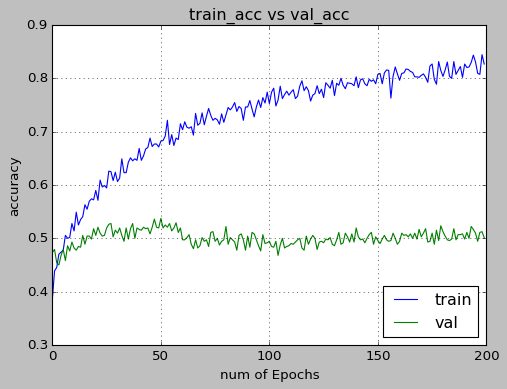

data fitted in model
creating predictions
predictions made
creating test file
       Type_1    Type_2    Type_3 image_name
0    0.140924  0.774300  0.084776      0.jpg
1    0.002546  0.332253  0.665201      1.jpg
2    0.193922  0.517466  0.288612     10.jpg
3    0.845732  0.145391  0.008877    100.jpg
4    0.608738  0.383170  0.008092    101.jpg
5    0.989222  0.010158  0.000620    102.jpg
6    0.737850  0.256632  0.005517    103.jpg
7    0.416587  0.129661  0.453751    104.jpg
8    0.506332  0.314851  0.178818    105.jpg
9    0.061165  0.150898  0.787937    106.jpg
10   0.778431  0.025540  0.196029    107.jpg
11   0.011923  0.833083  0.154995    108.jpg
12   0.015141  0.015734  0.969125    109.jpg
13   0.283386  0.033464  0.683150     11.jpg
14   0.007696  0.925611  0.066693    110.jpg
15   0.001644  0.945817  0.052540    111.jpg
16   0.017003  0.982289  0.000708    112.jpg
17   0.049897  0.941007  0.009095    113.jpg
18   0.423575  0.323642  0.252783    114.jpg
19   0.002989  0.43410

In [53]:
if __name__ == '__main__':
    
    test(isTrue = False)